In [1]:
from functools import partial
import numpy as np
from math import sqrt, log, pi, exp
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm

In [2]:
FACTOR_LOGNORMAL = 1.0 / ( sqrt(2.0*pi))

def lognormal(r, ksi=1.0, lambda_=1.0):
    
    par2 = -0.5*((log(r) - lambda_)/ksi)**2     
    
    return  par1 * exp(par2)

def sigma(mu, delta):
    return mu * delta

def ksi(delta):
    return sqrt(log(1.0+delta**2))

def lambda_(mu, ksi):
    return  log(mu) - 0.5 * ksi**2


def paramenters_lognormal(mu, delta):
    k = ksi(delta)    
    return sigma(mu, delta), k, lambda_(mu, k)

In [3]:
def tipoI(x, alpha, u):
    par1 = exp(-alpha * (x - u))
    return alpha*exp(-par1)*par1


def alpha(sig):
    return (pi/sqrt(6))*(1.0/sig)

def u(mu, alpha):
    return mu - 0.5772/alpha

# U1 - Temeratura intera

In [38]:
mu1, delta1 = 1.19, 0.1

sigma1, ksi1, lambda1 =  paramenters_lognormal(mu1, delta1)

print(f'sigma = {sigma1:.3f} ksi = {ksi1:.5f} lambda = {lambda1:.5f}')

sigma = 0.119 ksi = 0.09975 lambda = 0.16898


In [39]:
x = np.arange(0.01, mu1+10*sigma1, 0.01)
p = np.arange(0.0, 1.0, 0.001)

# 
# scale = exp μ, where μ is the mean of the log of the variate
# s = the standard deviation of the log of the variate

f1 = partial(lognorm.pdf, s=ksi1, scale=exp(lambda1))
F1 = partial(lognorm.cdf, s=ksi1, scale=exp(lambda1))
IF1 = partial(lognorm.ppf, s=ksi1, scale=exp(lambda1))

pdf = f1(x)
cdf = F1(x)
icdf = IF1(p)

In [40]:
def graph_pdf(x, pdf, mu, xlabel, ylabel):
    
    plt.figure(figsize=(8, 4))

    plt.plot(x, pdf, label='dist')
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.axvline(x = mu, color = 'r', label = 'Media')

    plt.legend()

    plt.show()
    

def graph_cdf(x, cdf, mu, xlabel, ylabel):

    plt.figure(figsize=(8, 4))
    
    plt.plot(x, cdf, label='dist')
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.axvline(x = mu, color = 'r', label = 'Media')

    plt.legend()

    plt.show()
    
def graph_icdf(x, icdf, mu, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    plt.plot(p, icdf, label='Função inversa Acumulada')
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.axhline(y = mu, color = 'r', label = 'Media')

    plt.legend()

    plt.show()

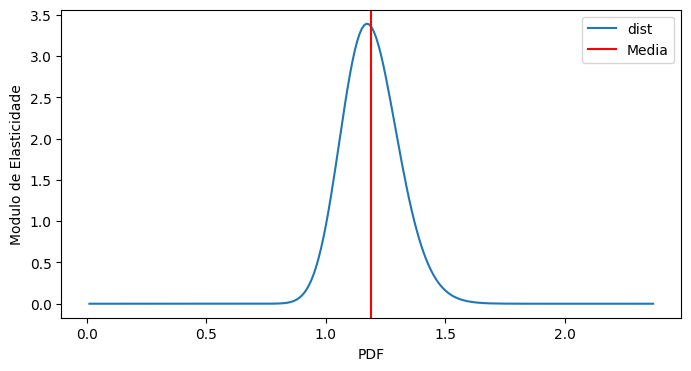

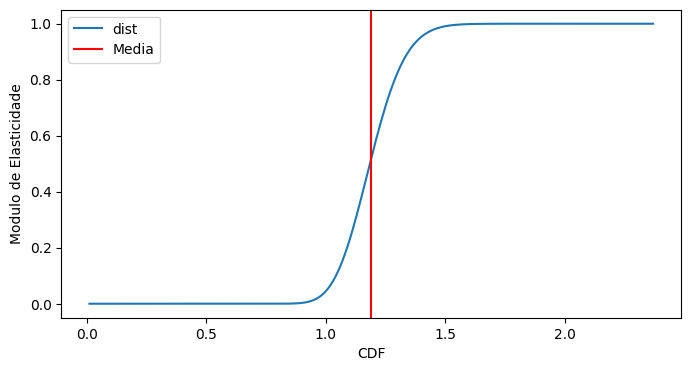

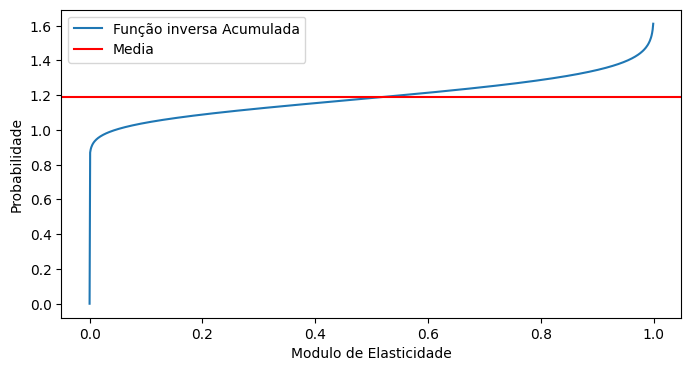

In [41]:
graph_pdf(x, pdf, mu1, 'Modulo de Elasticidade', 'PDF')
graph_cdf(x, cdf, mu1, 'Modulo de Elasticidade', 'CDF')
graph_icdf(x, icdf, mu1, 'Probabilidade', 'Modulo de Elasticidade')

# FORMS LOOP

In [42]:
def print_array(name, array):
    print(name, end=' ')
    for a in array:
        print(f'{a:.3e}', end=' ')
    print()
        
def array_V(Ua, list_of_F):
    cholesky = np.ones_like(Ua) 
    
    vector = np.zeros_like(Ua)
    for i, (u, F) in enumerate(zip(Ua, list_of_F)):
        vector[i] = norm.ppf(F(u))    
        
    return cholesky * vector


def array_Y(Va):
    
    cholesky = np.ones_like(Va)      
        
    return cholesky * Va


def array_U(Vn, IFs):
    
    Y =  array_Y(Vn)
    
    vector = np.zeros_like(Y)
    
    for i, (y, IF) in enumerate(zip(Y, IFs)):
        vector[i] = IF(norm.cdf(y))

    return vector

def matrix_A(Ua, fs, Fs):
    
    A = np.zeros_like(Ua)
    
    for i, (U, f, F) in enumerate(zip(Ua, fs, Fs)):
        A[i]= f(U) / norm.pdf(norm.ppf(F(U)))  
    
    return A
    
    
def i_matrix_A(A):
    return 1.0/A

In [43]:
fs = (f1,)
Fs = (F1,)
IFs = (IF1,)

## Iteração: 01

In [44]:
Ua = np.array([1.19,])
beta = 20
delta = 0.01
gamma = 0.3

# RCs
RC = .4378
novos_rcs =  np.array([0.4314])

Uaux = Ua*(1+delta)

Gi = RC - gamma
Gaux = novos_rcs - gamma

print('Gi', Gi)
print_array('Uaux', Uaux)
print_array('Gaux', Gaux)

Gi 0.13780000000000003
Uaux 1.202e+00 
Gaux 1.314e-01 


In [45]:
GradU = (Gaux - Gi)/(Ua*delta)

Vi = array_V(Ua, Fs)

A = matrix_A(Ua, fs, Fs)
iA = i_matrix_A(A)
Grad_gi = iA * GradU

Modg = np.linalg.norm(Grad_gi, ord=2)

Modg_square = Modg**2
Vn = ((np.dot(Grad_gi, Vi) - Gi) * Grad_gi) / Modg_square
betai = np.linalg.norm(Vn)

tol = abs(betai - beta) / betai

Un = array_U(Vn, IFs)

print_array('GradU', GradU)
print_array('Vi', Vi)
print_array('A', A)
print_array('iA', iA)
print_array('Grad_gi', Grad_gi)
print(f'Modg = |Grad_gi| = {Modg}')
print_array('Vn', Vn)
print(f'betai = |Vn| = {betai}')
print(f'tol = {tol:e}')  
print_array('Un', Un) 

GradU -5.378e-01 
Vi 4.988e-02 
A 8.424e+00 
iA 1.187e-01 
Grad_gi -6.384e-02 
Modg = |Grad_gi| = 0.06384086087653949
Vn 2.208e+00 
betai = |Vn| = 2.2083678687488253
tol = 8.056462e+00
Un 1.476e+00 


# Iteração 02:

In [46]:
Ua = np.array(Un)
beta = betai

# RCs
rc = 0.2881
novos_rcs =  np.array([0.2804])

Uaux = Ua*(1+delta)

Gi = rc - gamma
Gaux = novos_rcs - gamma

print('Gi', Gi)
print_array('Ua', Ua)
print_array('Uaux', Uaux)
print_array('Gaux', Gaux)

Gi -0.011899999999999966
Ua 1.476e+00 
Uaux 1.491e+00 
Gaux -1.960e-02 


In [47]:
GradU = (Gaux - Gi)/(Ua*delta)

Vi = array_V(Ua, Fs)
A = matrix_A(Ua, fs, Fs)
iA = i_matrix_A(A)
Grad_gi = iA * GradU

Modg = np.linalg.norm(Grad_gi, ord=2)

Modg_square = Modg**2
Vn = ((np.dot(Grad_gi, Vi) - Gi) * Grad_gi) / Modg_square
betai = np.linalg.norm(Vn)

tol = abs(betai - beta) / betai

Un = array_U(Vn, IFs)

print_array('GradU', GradU)
print_array('Vi', Vi)
print_array('A', A)
print_array('iA', A)
print_array('Grad_gi', Grad_gi)
print(f'Modg = |Grad_gi| = {Modg}')
print_array('Vn', Vn)
print(f'betai = |Vn| = {betai}')
print(f'tol = {tol:e}') 
print_array('Un', Un) 

GradU -5.217e-01 
Vi 2.208e+00 
A 6.792e+00 
iA 6.792e+00 
Grad_gi -7.681e-02 
Modg = |Grad_gi| = 0.07680853574208685
Vn 2.053e+00 
betai = |Vn| = 2.053437171463322
tol = 7.544945e-02
Un 1.453e+00 


# Iteração 03:

In [48]:
Ua = np.array(Un)
beta = betai

# RCs
rc = 0.2999
novos_rcs =  np.array([0.2922])

Uaux = Ua*(1+delta)

Gi = rc - gamma
Gaux = novos_rcs - gamma

print('Gi', Gi)
print_array('Ua', Ua)
print_array('Uaux', Uaux)
print_array('Gaux', Gaux)

Gi -9.999999999998899e-05
Ua 1.453e+00 
Uaux 1.468e+00 
Gaux -7.800e-03 


In [49]:
GradU = (Gaux - Gi)/(Ua*delta)

Vi = array_V(Ua, Fs)

A = matrix_A(Ua, fs, Fs)
iA = i_matrix_A(A)
Grad_gi = iA * GradU

Modg = np.linalg.norm(Grad_gi, ord=2)

Modg_square = Modg**2
Vn = ((np.dot(Grad_gi, Vi) - Gi) * Grad_gi) / Modg_square
betai = np.linalg.norm(Vn)

tol = abs(betai - beta) / betai

Un = array_U(Vn, IFs)

print_array('GradU', GradU)
print_array('Vi', Vi)
print_array('A', A)
print_array('iA', A)
print_array('Grad_gi', Grad_gi)
print(f'Modg = |Grad_gi| = {Modg}')
print_array('Vn', Vn)
print(f'betai = |Vn| = {betai}')
print(f'tol = {tol:e}') 
print_array('Un', Un) 

GradU -5.298e-01 
Vi 2.053e+00 
A 6.898e+00 
iA 6.898e+00 
Grad_gi -7.681e-02 
Modg = |Grad_gi| = 0.07680853574208632
Vn 2.052e+00 
betai = |Vn| = 2.0521352328306706
tol = 6.344312e-04
Un 1.453e+00 


# Resultado Final

In [50]:
beta_FORM = betai
Pf_FORM = norm.cdf(-betai)
alpha_FORM = Grad_gi / Modg


beta_FORM, Pf_FORM, alpha_FORM 

print(f'betaFORM = {beta_FORM:.4f} PfFORM = {Pf_FORM:.4e}')

betaFORM = 2.0521 PfFORM = 2.0078e-02


In [51]:
alpha_FORM

array([-1.])

## Fatores de importância

In [52]:
print('Fatores de importancias:')
for i, alf in enumerate(alpha_FORM):
    print(f'u_{i} = {100.0*alf**2:.4f} %')

Fatores de importancias:
u_0 = 100.0000 %


## Fatores de Omissão

In [53]:
print('Fatores de omisao:')
for i, alf in enumerate(alpha_FORM):
    gamma = 1.0 / sqrt(1 - alf**2)
    print(f'u_{i} = {gamma:.4f}')

Fatores de omisao:


ZeroDivisionError: float division by zero